In [30]:
import numpy as np
import os
from tsai.all import *
from fastai.data.all import *
import torch
import random
from utils import to_polar_coordinates, arg_parser, common_arg_parser, SaveLearningInfo
from fastai.callback.tensorboard import TensorBoardCallback
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

#Step0: GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [31]:
window_length = 100
horizon = 10
stride_num = 10
learn_num = 10
prefix = 'test'
X, y = [], []
test = True

In [32]:
excluded_values = [16, 20, 23]
random_values = []
while len(random_values) < 2:
    rand_num = random.randint(0, 24)
    if rand_num not in excluded_values and rand_num not in random_values:
        random_values.append(rand_num)
prefix = prefix + f'_patient_{random_values[0]}_{random_values[1]}'
for i in random_values:
    path = 'datasets/epic'
    patient_path = f"{path}/AB{str(i+6).zfill(2)}"
    folders_in_patient_path = [item for item in os.listdir(patient_path) if os.path.isdir(os.path.join(patient_path, item))]
    specific_folder_path = [folder for folder in folders_in_patient_path if folder != "osimxml"][0]

    if i==0:
        gon_path_ccw = f"{patient_path}/{specific_folder_path}/levelground/gon/levelground_ccw_normal_02_01.csv"
        imu_path_ccw = f"{patient_path}/{specific_folder_path}/levelground/imu/levelground_ccw_normal_02_01.csv"
        phase_path_ccw = f"{patient_path}/{specific_folder_path}/levelground/gcRight/levelground_ccw_normal_02_01.csv"
        gon_path_cw = f"{patient_path}/{specific_folder_path}/levelground/gon/levelground_cw_normal_02_01.csv"
        phase_path_cw = f"{patient_path}/{specific_folder_path}/levelground/gcRight/levelground_cw_normal_02_01.csv"
    else:
        gon_path_ccw = f"{patient_path}/{specific_folder_path}/levelground/gon/levelground_ccw_normal_01_02.csv"
        imu_path_ccw = f"{patient_path}/{specific_folder_path}/levelground/imu/levelground_ccw_normal_01_02.csv"
        phase_path_ccw = f"{patient_path}/{specific_folder_path}/levelground/gcRight/levelground_ccw_normal_01_02.csv"
        gon_path_cw = f"{patient_path}/{specific_folder_path}/levelground/gon/levelground_cw_normal_01_02.csv"
        imu_path_cw = f"{patient_path}/{specific_folder_path}/levelground/imu/levelground_cw_normal_02_01.csv"
        phase_path_cw = f"{patient_path}/{specific_folder_path}/levelground/gcRight/levelground_cw_normal_01_02.csv"

    gon_ccw = pd.read_csv(gon_path_ccw).iloc[::5, 4]
    imu_ccw = pd.read_csv(imu_path_ccw).iloc[:, 4]
    phase_ccw = pd.read_csv(phase_path_ccw).iloc[:, 1]
    input_data = np.concatenate((phase_ccw, gon_ccw.values))
    print(f"input data shape: {input_data.shape}")

    sw = SlidingWindow(window_length, stride= stride_num, get_y=[0], horizon=horizon) #Stride: 건너뛰는 양 / horizon: 예측하고 싶은 미래 step수
    X_window, y_window = sw(input_data)
    print(f"X_window shape: {X_window.shape} / Y_window shape: {y_window.shape}")
    X.extend(X_window)
    y.extend(y_window)
X = np.array(X)
y = np.array(y)
print(f"X shape: {X.shape} / Y shape: {y.shape}")

input data shape: (9004,)
X_window shape: (890, 1, 100) / Y_window shape: (890, 10)
input data shape: (7254,)
X_window shape: (715, 1, 100) / Y_window shape: (715, 10)
X shape: (1605, 1, 100) / Y shape: (1605, 10)


X      - shape: [1605 samples x 1 features x 100 timesteps]  type: ndarray  dtype:float64  isnan: 0
y      - shape: (1605, 10)  type: ndarray  dtype:float64  isnan: 0
splits - n_splits: 2 shape: [1284, 321]  overlap: False


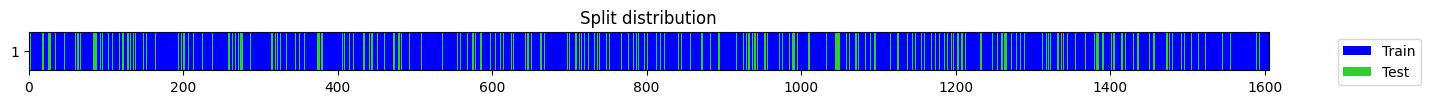

In [33]:
splits = get_splits(y, valid_size=0.2, stratify=False, random_state=23, shuffle=True, show_plot=False)
check_data(X, y, splits)

In [34]:
tfms  = [None, [TSForecasting()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=64, num_workers=0)
dls.one_batch()

(TSTensor(samples:64, vars:1, len:100, device=cuda:0, dtype=torch.float32),
 tensor([[ 5.7356e-02,  7.1525e-02,  7.3879e-02,  7.7632e-02,  9.5238e-02,
           1.3203e-01,  1.8561e-01,  2.4865e-01,  3.1258e-01,  3.7102e-01],
         [ 6.2126e+01,  6.2275e+01,  6.2425e+01,  6.2575e+01,  6.2725e+01,
           6.2874e+01,  6.3024e+01,  6.3174e+01,  6.3323e+01,  6.3473e+01],
         [-6.2690e+00, -6.3081e+00, -6.3447e+00, -6.4006e+00, -6.4904e+00,
          -6.6155e+00, -6.7640e+00, -6.9182e+00, -7.0639e+00, -7.1962e+00],
         [ 6.4840e+01,  6.5297e+01,  6.5753e+01,  6.6210e+01,  6.6667e+01,
           6.7123e+01,  6.7580e+01,  6.8037e+01,  6.8493e+01,  6.8950e+01],
         [ 3.0000e+01,  3.0435e+01,  3.0870e+01,  3.1304e+01,  3.1739e+01,
           3.2174e+01,  3.2609e+01,  3.3043e+01,  3.3478e+01,  3.3913e+01],
         [ 1.8092e+01,  1.7923e+01,  1.7721e+01,  1.7465e+01,  1.7144e+01,
           1.6757e+01,  1.6314e+01,  1.5836e+01,  1.5353e+01,  1.4893e+01],
         [-1.0447e

In [35]:
dls.c

1

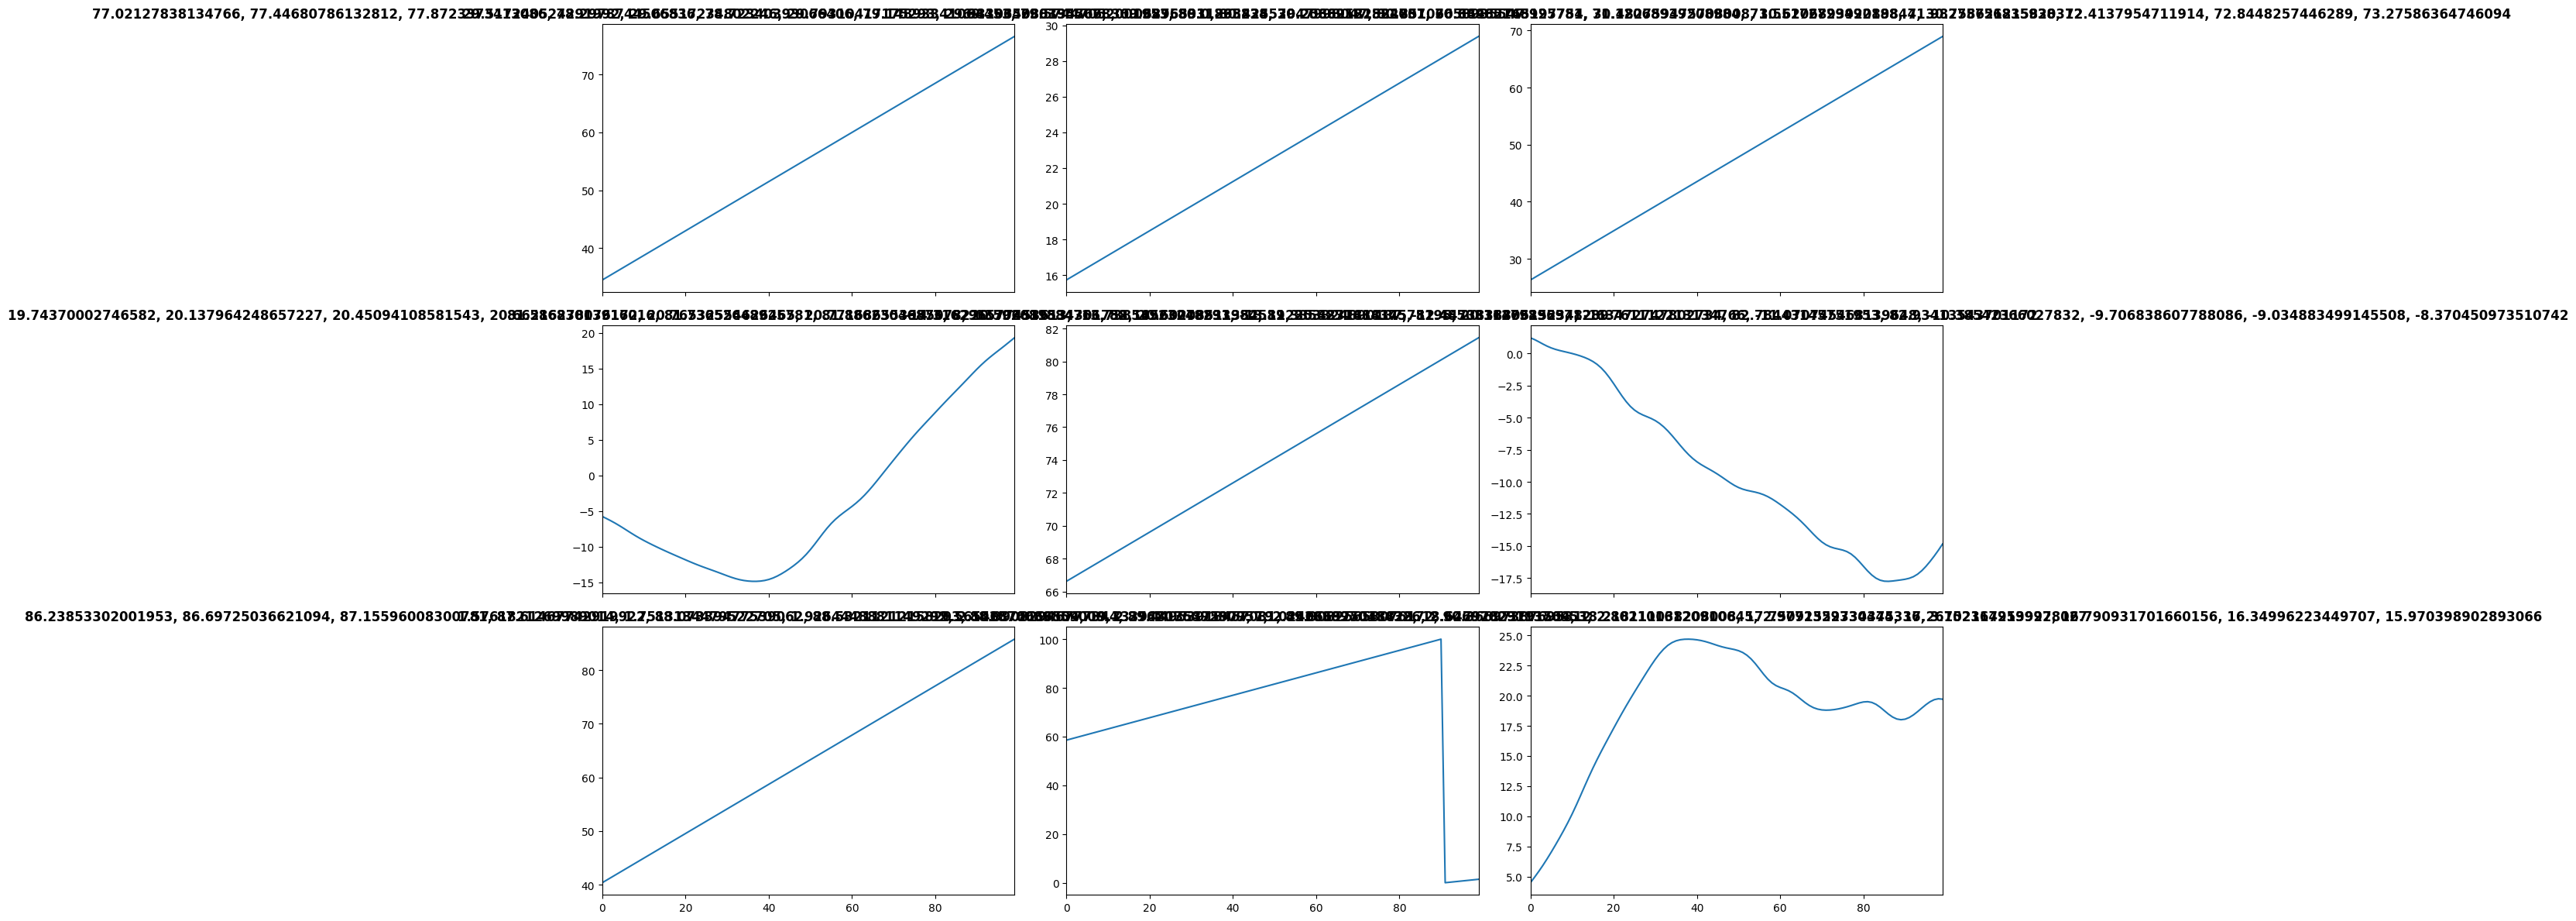

In [36]:
dls.show_batch()

In [37]:
model = InceptionTimePlus(X.shape[1], y.shape[1])
#model = PatchTST(X.shape[1], y.shape[1], seq_len = args.horizon)
learn = Learner(dls, model, metrics=rmse)
#learn = TSFore

In [39]:
if test == False:
    os.makedirs('models/prediction/', exist_ok=True)
    learn.fit_one_cycle(learn_num, 1e-3)
    learn.export(f"models/prediction/{prefix}")

    learn.export(f"prediction/{prefix}.pt")
    learn.export(f"prediction/{prefix}.pth")
    print(f"Finish Learning. Model is at prediction/{prefix}")
else:
    del learn
    #테스트 구간
    learn = load_learner(f"models/prediction/test_patient_8_11.pth", cpu=False)